In [6]:
import pandas as pd
df = pd.read_csv(r"D:\NLP\Combined Data.csv\Combined Data.csv")
print(df.head())

   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


In [7]:
print(df.isnull().sum())
df.dropna(inplace=True)

Unnamed: 0      0
statement     362
status          0
dtype: int64


C:\Users\HiTech\AppData\Local\Temp\ipykernel_13820\1347960447.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette="viridis")


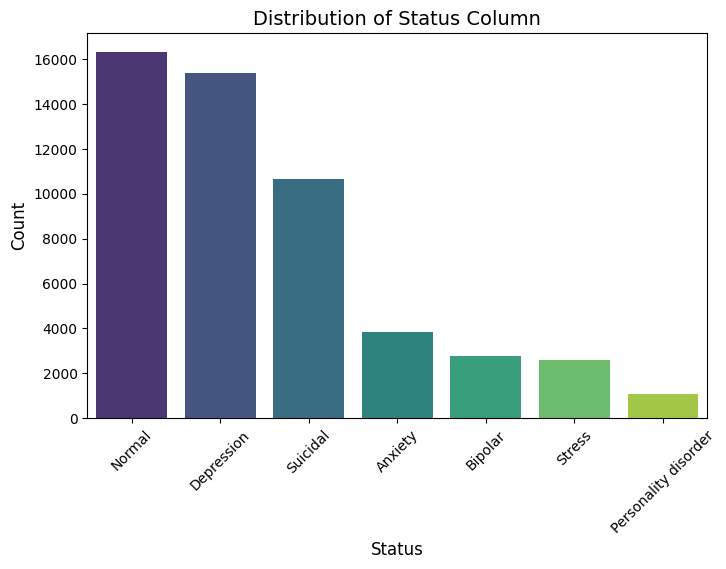

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each status
status_counts = df["status"].value_counts()

# Plot the bar graph
plt.figure(figsize=(8, 5))
sns.barplot(x=status_counts.index, y=status_counts.values, palette="viridis")

# Add labels and title
plt.xlabel("Status", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Status Column", fontsize=14)
plt.xticks(rotation=45)  # Rotate labels if needed

# Save the figure before showing it
plt.savefig("status_distribution.png", dpi=300, bbox_inches="tight")  # Save as PNG with high resolution

# Show the plot
plt.show()

In [8]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import wandb


label_mapping = {label: idx for idx, label in enumerate(sorted(df['status'].unique()))}
df['label']=df['status'].map(label_mapping)

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

MAX_LENGTH = 128

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = tokenizer(text, padding="max_length", truncation=True, max_length=MAX_LENGTH, return_tensors="pt")
        return {"input_ids": encoding["input_ids"].squeeze(0),
                "attention_mask": encoding["attention_mask"].squeeze(0),
                "label": torch.tensor(label, dtype=torch.long)}
    

In [9]:
def collate_fn(batch):
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_mask = torch.stack([item["attention_mask"] for item in batch])
    labels = torch.tensor([item["label"] for item in batch], dtype=torch.long)
    return {"input_ids": input_ids, "attention_mask": attention_mask, "label": labels}


In [18]:
X_train, X_test, y_train, y_test = train_test_split(df["statement"], df["label"], test_size=0.1, random_state=42)
train_dataset = SentimentDataset(X_train.tolist(), y_train.tolist(), tokenizer=tokenizer, max_length=MAX_LENGTH)
test_dataset = SentimentDataset(X_test.tolist(), y_test.tolist(), tokenizer=tokenizer, max_length=MAX_LENGTH)
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [11]:
print(label_mapping)  # Ensure labels start from 0 and are sequential
print(df["label"].unique())  # Ensure no label is larger than num_labels-1


{'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}
[0 3 2 6 5 1 4]


In [51]:
from transformers import get_scheduler
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support


class BERTTrainer:
    def __init__(self, model, train_loader, val_loader, device, learning_rate=2e-5):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.learning_rate = learning_rate

    def train(self, epochs = 5, early_stopping_patience=2):
        """Train the model with early stopping"""
        optimizer = optim.AdamW(self.model.parameters(), lr=self.learning_rate)
        scheduler = get_scheduler(
                            "linear",
                            optimizer=optimizer,
                            num_warmup_steps=0,
                            num_training_steps=len(self.train_loader) * epochs,
                            )
        best_val_loss = float('inf')
        patience_counter = 0
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        
        for epoch in range(epochs):
            self.model.train()
            train_loss, train_acc = self._train_epoch(optimizer, scheduler)

            val_loss, val_acc, val_precision, val_recall, val_f1 = self.evaluate(self.val_loader)
            print(f"Val Precision: {val_precision:.4f} | Val Recall: {val_recall:.4f} | Val F1: {val_f1:.4f}")

            # Early stopping logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), 'best_model.pt')
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f"Early stopping triggered after {epoch + 1} epochs")
                    break
            
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        return history

    def _train_epoch(self, optimizer, scheduler):
        """Train for one epoch"""
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        
        progress_bar = tqdm(self.train_loader, desc="Training")

        for batch in progress_bar:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['label'].to(self.device)

            outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            

            total_loss += loss.item()
            predictions = torch.argmax(outputs.logits, dim=1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

            progress_bar.set_postfix({'loss': loss.item()})
        
        avg_loss = total_loss / len(self.train_loader)
        accuracy = correct_predictions / total_predictions
        
        return avg_loss, accuracy

    def evaluate(self, dataloader):
        """Evaluate model and return loss, accuracy, precision, recall, and F1-score"""
        self.model.eval()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['label'].to(self.device)

                outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
                total_loss += outputs.loss.item()
                
                predictions = torch.argmax(outputs.logits, dim=1)
                all_preds.extend(predictions.cpu().tolist())
                all_labels.extend(labels.cpu().tolist())

                correct_predictions += (predictions == labels).sum().item()
                total_predictions += labels.size(0)

        avg_loss = total_loss / len(dataloader)
        accuracy = correct_predictions / total_predictions
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')

        return avg_loss, accuracy, precision, recall, f1

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=7)
model.to(device)
trainer = BERTTrainer(model, train_loader, test_loader, device)
history = trainer.train(epochs=5, early_stopping_patience=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training: 100%|██████████| 5268/5268 [7:11:28<00:00,  4.91s/it, loss=0.23]     


Val Precision: 0.8158 | Val Recall: 0.8094 | Val F1: 0.8084
Epoch 1/5: Train Loss: 0.5568 | Train Acc: 0.7810 | Val Loss: 0.4525 | Val Acc: 0.8094


Training: 100%|██████████| 5268/5268 [7:04:55<00:00,  4.84s/it, loss=0.947]    


Val Precision: 0.8328 | Val Recall: 0.8317 | Val F1: 0.8309
Epoch 2/5: Train Loss: 0.3466 | Train Acc: 0.8571 | Val Loss: 0.4173 | Val Acc: 0.8317


Training: 100%|██████████| 5268/5268 [7:02:16<00:00,  4.81s/it, loss=0.549]    


Val Precision: 0.8361 | Val Recall: 0.8343 | Val F1: 0.8346
Epoch 3/5: Train Loss: 0.2226 | Train Acc: 0.9118 | Val Loss: 0.4445 | Val Acc: 0.8343


Training: 100%|██████████| 5268/5268 [7:13:42<00:00,  4.94s/it, loss=0.0212]    


Val Precision: 0.8310 | Val Recall: 0.8315 | Val F1: 0.8303
Early stopping triggered after 4 epochs


In [ ]:
torch.save(model, "final_model_complete.pt")
print("✅ Complete model saved as 'final_model_complete.pt'")

✅ Complete model saved as 'final_model_complete.pt'


In [19]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reinitialize the model architecture (must match original)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=7)  

# Load the saved state dictionary
model.load_state_dict(torch.load("best_model.pt", map_location=device))

# Send to device and set to eval mode
model.to(device)
model.eval()

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("📊 Classification Report:\n", classification_report(all_labels, all_preds))
    return all_labels, all_preds

# Run evaluation
y_true, y_pred = evaluate_model(model, test_loader)


📊 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88       371
           1       0.84      0.92      0.88       273
           2       0.79      0.72      0.75      1521
           3       0.96      0.96      0.96      1655
           4       0.66      0.83      0.74       114
           5       0.80      0.69      0.74       258
           6       0.70      0.75      0.73      1077

    accuracy                           0.83      5269
   macro avg       0.80      0.83      0.81      5269
weighted avg       0.83      0.83      0.83      5269



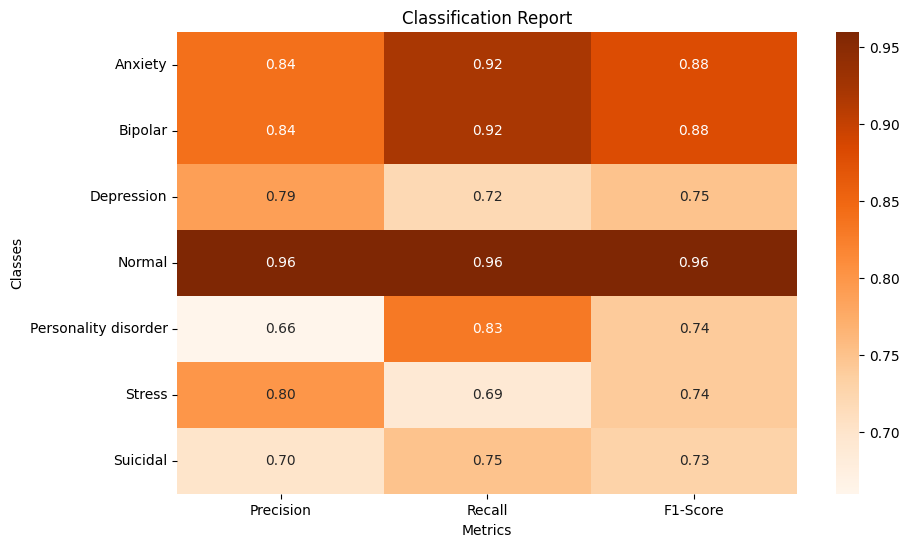

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
{'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}

# Classification report (as extracted from text)
report_dict = {
    "Anxiety": [0.84, 0.92, 0.88, 371],
    "Bipolar": [0.84, 0.92, 0.88, 273],
    "Depression": [0.79, 0.72, 0.75, 1521],
    "Normal": [0.96, 0.96, 0.96, 1655],
    "Personality disorder": [0.66, 0.83, 0.74, 114],
    "Stress": [0.80, 0.69, 0.74, 258],
    "Suicidal": [0.70, 0.75, 0.73, 1077],
}

# Convert to numpy array
labels = list(report_dict.keys())
metrics = ["Precision", "Recall", "F1-Score", "Support"]
data = np.array(list(report_dict.values()))

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data[:, :-1], annot=True, fmt=".2f", cmap="Oranges", xticklabels=metrics[:-1], yticklabels=labels)
plt.title("Classification Report")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()

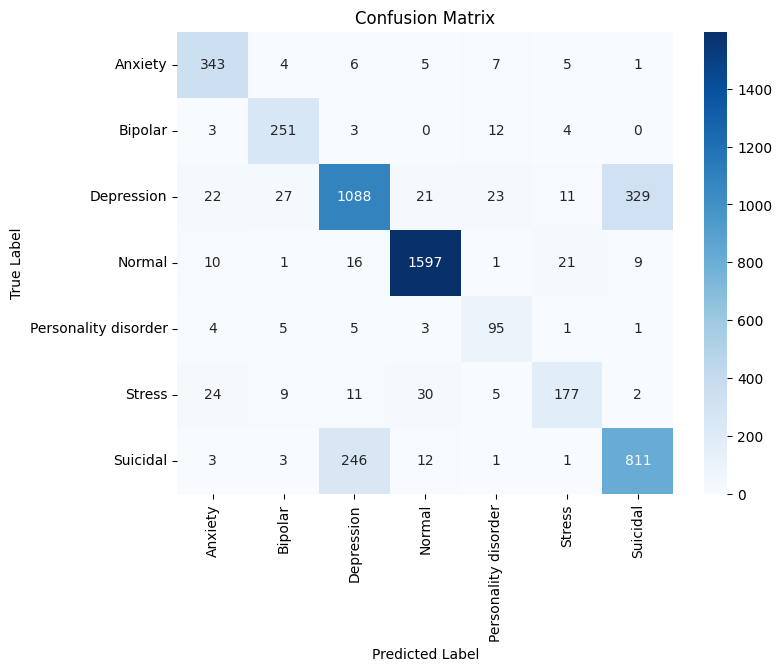

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

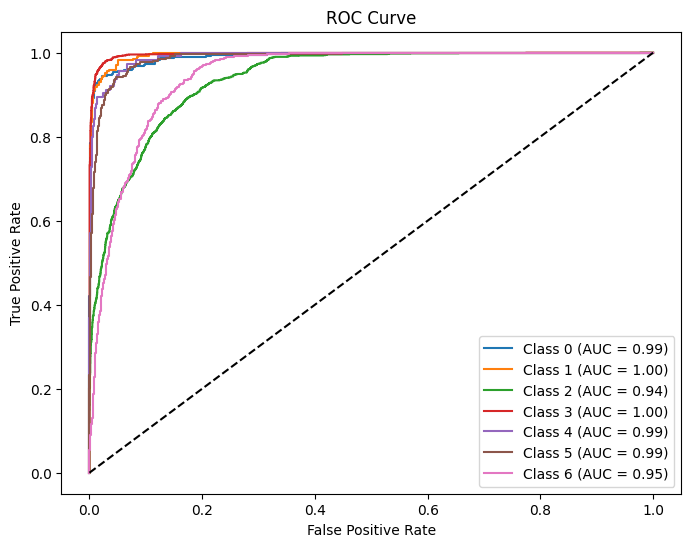

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Ensure model is in eval mode
model.eval()

# Store true labels and predicted probabilities
y_true = []
y_pred_probs = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].cpu().numpy()  # Store true labels

        # Get predictions
        outputs = model(input_ids, attention_mask=attention_mask)
        probs = outputs.logits.softmax(dim=1).cpu().numpy()  # Convert logits to probabilities

        # Store values
        y_true.extend(labels)
        y_pred_probs.extend(probs)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Convert true labels to one-hot encoding
num_classes = len(set(y_true))
y_true_one_hot = np.eye(num_classes)[y_true]

# Plot ROC Curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Random chance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


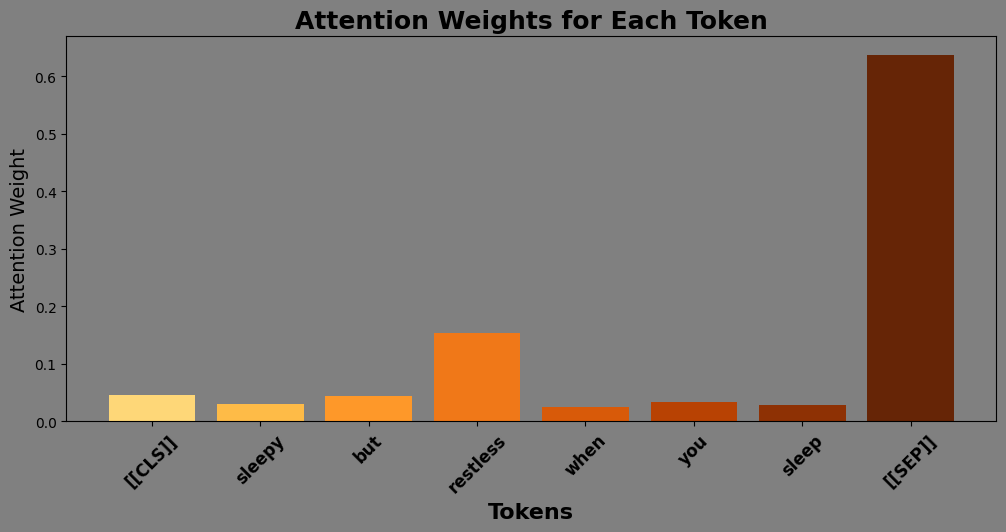

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def get_attention_weights(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attentions = outputs.attentions  # Extract attention scores
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())

    return tokens, attentions[-1].mean(dim=0).squeeze().cpu().numpy()  # Averaging over heads

# Test Example
text_example = "Sleepy but restless when you sleep"
tokens, attention_weights = get_attention_weights(text_example)

# Ensure attention_weights is 1D
avg_attention = attention_weights.mean(axis=0).flatten()  # Ensuring a 1D array

# Ensure lengths match
if len(avg_attention) > len(tokens):
    avg_attention = avg_attention[:len(tokens)]  # Trim if extra values
elif len(avg_attention) < len(tokens):
    tokens = tokens[:len(avg_attention)]  # Trim tokens if needed

# Convert tokens into valid labels for plotting (matplotlib doesn't support special tokens)
tokens = [t if t.isalnum() else f"[{t}]" for t in tokens]  # Replace special tokens for visualization

# Generate a gradient from light yellow to deep yellow
colors = plt.cm.YlOrBr(np.linspace(0.3, 1, len(tokens)))  # Light yellow to dark yellow

# Set grey background
plt.figure(figsize=(12, 5), facecolor="grey")
ax = plt.gca()
ax.set_facecolor("grey")  # Set axis background to grey

# Plot attention scores
bars = plt.bar(range(len(tokens)), avg_attention, color=colors)

# Customize labels
plt.xticks(range(len(tokens)), tokens, rotation=45, fontsize=12, fontweight="bold", color="black")  # Bold x-axis labels in black
plt.xlabel("Tokens", fontsize=16, fontweight="bold", color="black")  # Bigger and bold x-axis label in black
plt.ylabel("Attention Weight", fontsize=14, color="black")  # Bigger y-axis label in black
plt.title("Attention Weights for Each Token", fontsize=18, fontweight="bold", color="black")  # Bigger and bold title in black

# Set spines and tick colors to black for visibility
for spine in ax.spines.values():
    spine.set_color("black")
ax.yaxis.label.set_color("black")
ax.xaxis.label.set_color("black")
ax.tick_params(axis="y", colors="black")

# Show the plot
plt.show()
